<div align=center class="alert alert-block alert-info">
    <h1>IBM Quantum Challenge Africa:</h1>
        <h1>Quantum Chemistry for HIV</h1>
</div>

<img src="HIV-1_capsid_wikipedia.png"/>

<div align=center class="alert alert-block alert-info">
    <h1>Table of Contents</h1>
</div>

| Walk-through |
|:-|
|[Preface](#preface)|
|[Introduction](#intro)|
|[Step 1 : Defining the Molecular Geometry](#step_1)|
|[Step 2 : Calculating the Qubit Hamiltonian](#step_2)|
|[Step 2a: Constructing the Fermionic Hamiltonion](#step_3)|
|[Step 2b: Getting Ready to Convert to a Qubit Hamiltonian](#step_2b)|
|[Step 3 : Setting up the Variational Quantum Eigensolver (VQE)](#step_3)|
|[Step 3a: The V in VQE (i.e. the Variational form, a Trial state)](#step_3a)|
|[Step 3b: The Q in VQE: the Quantum environment](#step_3b)|
|[Step 3c: Initializing VQE](#step_3c)|
|[Step 4 : Solving for the Ground-state](#step_4)|
||
|[The HIV Challenge](#challenge)|
|[1. Refining Step 1: Varying the Molecule](#refine_step_1)|
|[2. Refining Step 2: Reducing the quantum workload](#refine_step_2)|
|[3. Refining Step 4: Energy Surface](#refine_step_4)|
|[4. Refining Step 3a](#refine_step_3a)|
|Exercises|
|[Exercise 3a: Molecular Definition of Macromolecule with Blocking Approach](#exercise_3a)|
|[Exercise 3b: Classical-Quantum Treatment Conceptual Questions (Multiple-Choice)](#exercise_3b)|
|[Exercise 3c: Energy Landscape, To bind or not to bind?](#exercise_3c)|
|[Exercise 3d: The effect of more repetitions](#exercise_3d)|
|[Exercise 3e: Open-ended: Find the best hardware_inspired_trial to minimize the Energy Error for the Macromolecule](#exercise_3e)|
|[Quantum Chemistry Resources](#qresource)|

<h2><a id='preface'>Preface</a></h2>


**HIV is a virus that has presented an immense challenge for public health, globally**. The ensuing disease dynamics touch on multiple societal dimensions including nutrition, access to health, education and research funding. To compound the difficulties, the virus mutates rapidly with different strains having different geographic footprints. In particular, the HIV-1-C and HIV-2 strains predominate mostly in Africa. Due to disparities in funding, research for treatments of the African strains lags behind other programmes. African researchers are striving to address this imbalance and should consider adding the latest technologies such as quantum computing to their toolkits.

**Quantum computing promises spectacular improvements in drug-design**. In particular, in order to design new anti-retrovirals it is important to perform **chemical simulations** to confirm that the anti-retroviral binds with the virus protein. Such simulations are notoriously hard and sometimes ineffective on classical supercomputers. Quantum computers promise more accurate simulations allowing for a better drug-design workflow.

In detail: anti-retrovirals are drugs that bind with and block a virus protein, called protease, that cleaves virus polyproteins into smaller proteins, ready for packaging. The protease can be thought of as a chemical scissor. The anti-retroviral can be thought of as a sticky obstacle that disrupts the ability of the scissor to cut. With the protease blocked, the virus cannot make more copies of itself.

Mutations in the viral protease changes the binding propensity of a given anti-retroviral. Hence, when a mutation occurs and an anti-retroviral no longer binds well, the goal becomes to adjust the anti-retroviral molecule to again bind strongly.

**The main goal of this challenge is to explore whether a toy anti-retroviral molecule binds with a toy virus protease.**

Along the way, this challenge introduces **state-of-the-art hybrid classical-quantum embedded chemistry modelling** allowing the splitting of the work-load between classical approximations and more accurate quantum calculations.

Finally, you need to tweak the setup of the quantum chemistry algorithm (without having to understand the nuts and bolts of quantum computing) to achieve the best performance for ideal quantum computing conditions.

*A video explaining how HIV infects and how anti-retroviral treatment works*:

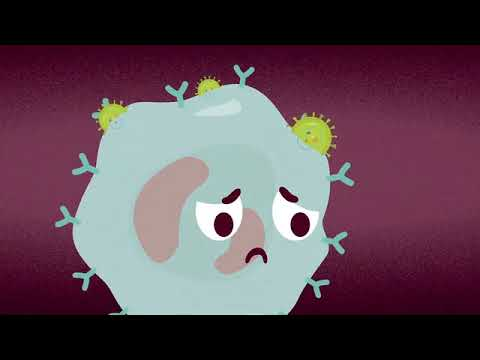

In [1]:
from IPython.display import display, YouTubeVideo
YouTubeVideo('cSNaBui2IM8')

<div align=center class="alert alert-block alert-success">
    <h1>Walk-through: Calculating the Ground-state Energy for the Simplest Molecule in the Universe</h1>
</div>

*Import relevant packages*

In [1]:
from qiskit import Aer

from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver

from qiskit.utils import QuantumInstance

from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit.circuit.library import TwoLocal

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

from functools import partial as apply_variation_to_atom_pair
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


<h2><a id='intro'>Introduction</a></h2>

In the HIV Challenge, we are tasked with investigating whether the toy anti-retroviral molecule binds with and therefore, disrupts the toy protease molecule. Successful binding is determined by a lower total ground-state energy for the molecules when they are close together (forming a single macromolecule) compared to far apart.

Total ground-state energy refers to the sum of the energies concerning the arrangement of the electrons and the nuclei. The nuclear energy is easy to calculate classically. It is the energy of the electron distribution (i.e. molecular spin-orbital occupation) that is extremely difficult and requires a quantum computer.

We start with a walk-through tutorial, where we calculate the ground-state energy of a simple molecule and leave the more complicated set-up to the challenge section.

The ground-state of a molecule in some configuration consists of the locations of the nuclei, together with some distribution of electrons around the nuclei. The nucleus-nucleus, nuclei-electron and electron-electron forces/energy of attraction and repulsion are captured in a matrix called the **Hamiltonian**. Since the nuclei are relatively massive compared to the electrons, they move at a slower time-scale than the electrons. This allows us to split the calculation into two parts: placing the nuclei and calculating the electron distribution, followed by moving the nuclei and recalculating the electron distribution until a minimum total energy distribution is reached:

<div class="alert alert-block alert-warning">
<b>Algorithm: Find_total_ground_state</b>

Place nuclei
    
Repeat until grid completed or no change in total_energy:
    
  - calculate electronic ground-state
    
  - total_energy = (nuclei repulsion + electronic energy)
    
  - move nuclei (either in grid or following gradient)

return total_energy
</div>

In the walk-through, we simply fix the nuclei positions; however, later, in the challenge section, we allow for a varying one-dimensional intermolecular distance between the anti-retroviral and the protease molecules, which represents the anti-retroviral approaching the protease molecule in an attempt to bind.

<h2><a id='step_1'>Step 1: Defining the Molecular Geometry</a></h2>

For this walk-through, we work with the simplest non-trivial molecule possible: H$_2$, the hydrogen gas molecule.

<img src="h2.png"/>

*The first thing to do is to fix the location of each nucleus. This is specified as a python list of nuclei, where each nucleus (as a list) contains a string corresponding to the atomic species and its 3D co-ordinates (as another list). We also specify the overall charge, which tells Qiskit to automatically calculate the number of needed electrons to produce that charge:*

In [2]:
hydrogen_molecule = Molecule(geometry=
                             [['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)

<h2><a id='step_2'>Step 2: Calculating the Qubit Hamiltonian</a></h2>

Once nuclei positions are fixed (the nucleus-nucleus forces are temporarily irrelevant), the only part of the Hamiltonian that then needs to be calculated on the quantum computer is the detailed electron-electron interaction. The nuclei-electron and a rough mean field electron-electron interaction can be pre-computed as *allowed molecular orbitals* on a classical computer via the, so called, Hartree-Fock approximation. With these allowed molecular orbitals and their pre-calculated overlaps, Qiskit automatically produces an interacting electron-electron **fermionic molecular-orbital Hamiltonian** (called Second Quantization). The molecular orbital and overlap pre-calculation are provided by classical packages, e.g. PySCF, and connected to Qiskit via a so-called *driver*, in particular, we use the PySCFDriver.

<h3><a id='step_3'>Step 2a: Constructing the Fermionic Hamiltonion</a></h3>

*We specify the driver to the classical software package that is to be used to calculate the resulting orbitals of the provided molecule after taking into account the nuclei-electron and mean-field interactions. The `basis` option selects the basis set in which the molecular orbitals are to be expanded in. `sto3g` is the smallest available basis set:*

In [3]:
molecular_hydrogen_orbital_maker = PySCFDriver(molecule=hydrogen_molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

*Qiskit provides a helpful Class named the ElectronicStructureProblem, which calls the driver in the right way to construct the molecular orbitals. We initialise ElectronicStructureProblem with the driver (which already has the molecular information stored in it from the previous step):*

In [4]:
hydrogen_fermionic_hamiltonian = ElectronicStructureProblem(molecular_hydrogen_orbital_maker)

*Here, we instruct the ElectronicStructureProblem object to go ahead and create the fermionic molecular-orbital Hamiltonian (which gets stored internally):*

In [5]:
hydrogen_fermionic_hamiltonian.second_q_ops()
print("Completed running classical package.\nFermionic molecular-orbital Hamiltonian calculated and stored internally.")
print("An example of HF info available: Orbital Energies", hydrogen_fermionic_hamiltonian._molecule_data_transformed.orbital_energies)

Completed running classical package.
Fermionic molecular-orbital Hamiltonian calculated and stored internally.
An example of HF info available: Orbital Energies [-0.58062892  0.67633625]


(If this step is not run explicitly, and its outputs are not used in an intermediary step, the final ground_state solving step would run it automatically.)

<h3><a id='step_2b'>Step 2b: Getting Ready to Convert to a Qubit Hamiltonian</a></h3>

Above, *fermionic* is a term to describe the behaviour of electrons (having an anti-symmetric wave-function obeying the Pauli Exclusion principle). In order to use the quantum computer we need to map the electrons (which exhibit fermionic behavior) to the quantum computer's qubits (which have closely related spin behaviour: Pauli Exclusion but not necessarily anti-symmetric). This mapping is a generic process, independent of the driver above.

There are multiple mapping methods available, each with pros and cons, and constitutes something to experiment with.

*For now, we select the simplest qubit mapper/converter called the Jordan-Wigner Mapper:*

In [6]:
map_fermions_to_qubits = QubitConverter(JordanWignerMapper())
# e.g. alternative:
# map_fermions_to_qubits = QubitConverter(BravyiKitaevMapper())

(Note, we have just chosen the mapper above, it has not yet been applied to the fermionic Hamiltonian.)

<h2><a id='step_3'>Step 3: Setting up the Variational Quantum Eigensolver (VQE)</a></h2>

Now that we have defined the molecule and its mapping onto a quantum computer, we need to select an algorithm to solve for the ground state. There are two well-known approaches: Quantum Phase Estimation (QPE) and VQE. The first requires fault-tolerant quantum computers that have not yet been built. The second is suitable for current day, noisy **depth**-restricted quantum computers, because it is a hybrid quantum-classical method with short-depth quantum circuits. By *depth* of the circuit, it suffices to know that quantum computers can only be run for a short while, before noise completely scrambles the results.

Therefore, for now, we only explore the VQE method. Furthermore, VQE offers many opportunities to tweak its configuration; thus, as an end-user you gain experience in quantum black-box tweaking.

<img src="vqe_method_NB.png"/>

VQE is an algorithm for finding the ground-state of a molecule (or any Hamiltonian in general). It is a hybrid quantum-classical algorithm, which means that the algorithm consists of two interacting stages, a quantum stage and a classical stage. 

During the quantum stage, a trial molecular state is created on the quantum computer. The trial state is specified by a collection of **parameters** which are provided and adjusted by the classical stage. After the trial state is created, its energy is calculated on the quantum computer (by a few rounds of quantum-classical measurements). The result is finally available classically. 

At this stage, a classical optimization algorithm looks at the previous energy levels and the new energy level and decides how to adjust the trial state parameters. This process repeats until the energy essentially stops decreasing. The output of the whole algorithm is the final set of parameters that produced the winning approximation to the ground-state and its energy level.

<h3><a id='step_3a'>Step 3a: The V in VQE (i.e. the Variational form, a Trial state)</a></h3>

VQE works by 'searching' for the electron orbital occupation distribution with the lowest energy, called the ground-state. The quantum computer is repeatedly used to calculate the energy of the search trial state.

The trial state is specified by a collection of (randomly initialized) parameters that move the state around, in our search for the ground-state (we're minimizing the energy cost-function). The form of the 'movement' is something that can be tweaked (i.e., the definition of the structure of the *ansatz*/trial). There are two broad approaches we could follow. The first, let's call it *Chemistry-Inspired Trial-states*, is to use domain knowledge of what we expect the ground-state to look like from a chemistry point of view and build that into our trial state. The second, let's call it *Hardware-Inspired Trial-states*, is to simply try and create trial states that have as wide a reach as possible while taking into account the architecure of the available quantum computers.

#### *Chemistry-Inspired Trial-states*

Since chemistry gives us domain-specific prior information (e.g., the number of orbitals and electrons and the actual Hartree-Fock approximation), it makes sense to guide the trial state by baking this knowledge into the form of the trial.

*From the HF approximation we get the number of orbitals and from that we can calculate the number of spin orbitals:*

In [7]:
hydrogen_molecule_info          = hydrogen_fermionic_hamiltonian.molecule_data_transformed
num_hydrogen_molecular_orbitals = hydrogen_molecule_info.num_molecular_orbitals
num_hydrogen_spin_orbitals      = 2 * num_hydrogen_molecular_orbitals

*Furthermore, we can also extract the number of electrons (spin up and spin down):*

In [8]:
num_hydrogen_electrons_spin_up_spin_down = (hydrogen_molecule_info.num_alpha, hydrogen_molecule_info.num_beta)

In [9]:
num_hydrogen_electrons_spin_up_spin_down 

(1, 1)

*With the number of spin orbitals, the number of electrons able to fill them and the mapping from fermions to qubits, we can construct an initial quantum computing state for our trial state:*

In [10]:
hydrogen_initial_state = HartreeFock(num_hydrogen_spin_orbitals,
                                     num_hydrogen_electrons_spin_up_spin_down,
                                     map_fermions_to_qubits)

*Finally, Qiskit provides a Class (Unitary Coupled Cluster Single and Double excitations, `UCCSD`) that takes the above information and creates a parameterised state inspired by the HF approximation, that can be iteratively adjusted in our attempt to find the ground-state:*

In [11]:
# this creates a parameterized quantum state taking into account the chemistry of the molecule 

hydrogen_chemistry_inspired_trial = UCCSD(map_fermions_to_qubits,
                                          num_hydrogen_electrons_spin_up_spin_down,
                                          num_hydrogen_spin_orbitals,
                                          initial_state=hydrogen_initial_state)

#### *Hardware-Inspired Trial-states*

The problem with the above "chemistry-inspired" trial-states, is that they are quite deep, quickly using up the available depth of current-day quantum computers. A potential solution is to forgo this chemistry knowledge and try to represent arbitrary states with trial states that are easy to prepare and parametrically "move" around on current hardware. There are two quantum operations that can be used to try and reach arbitrary states: mixing (our term for *conditional sub-space rotation*) and rotating (*unconditional rotation*). Detailed knowledge of how these operations and their sub-options work are not really needed, especially because it is not immediately obvious which settings produce the best results.

##### Mixing (also called Entanglement maps)

There are a set of available mixing strategies, that you may experiment with. This is specified with two arguments, *`entanglement`* (choosing what to mix) and *`entanglement_blocks`* (choosing how to mix):

Possible *`entanglement`* values: `'linear'`, `'full'`, `'circular'`, `'sca'`

Possible *`entanglement_blocks`* values: `'cz'`, `'cx'`

For our purposes, it is acceptable to simply choose the first option for each setting.
  
##### Rotation

There are a set of available *parameterized* rotation strategies. The rotation strategies are specified as a single argument, *`rotation_blocks`*, in the form of a list of any combination of the following possibilities:

Possible *`rotation_blocks`*: `'ry'`, `'rx'`,`'rz'`,`'h'`, ...

Typically, this is the only place that parameters are introduced in the trial state. One parameter is introduced for every rotation, corresponding to the angle of rotation around the associated axis. (Note, `'h'` does not have any parameters and so can not be selected alone.)

Again, for our purposes, an acceptable choice is the first option alone in the list.

*Qiskit provides a Class called `TwoLocal` for creating random trial states by local operations only. The number of **rounds** of the local operations is specified by the argument `reps`:*

In [12]:
# TwoLocal means making the initial trial state via hardware inspirations

hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=2)

(Note, this trial state does not depend on the molecule.)

*Just for convenience, let's choose between the two approaches by assiging the choice to a variable:*

In [13]:
hydrogen_trial_state = hydrogen_chemistry_inspired_trial
# OR
# hydrogen_trial_state = hardware_inspired_trial

<h3><a id='step_3b'>Step 3b: The Q in VQE: the Quantum environment</a></h3>

Since VQE runs on a quantum computer, it needs information about this stage. For testing purposes, this can even be a simulation, both in the form of noise-free or noisy simulations. Ultimately, we would want to run VQE an actual (albeit noisy) quantum hardware and hopefully, in the not-too-distant future, achieve results unattainable classically. For this challenge, let us pursue noise-free simulation only.

#### Noise-Free Simulation

*To set up a noise-free simulation:*

In [14]:
noise_free_quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))

<h3><a id='step_3c'>Step 3c: Initializing VQE</a></h3>

Qiskit Nature provides a class called VQE, that implements the VQE algorithm. *It is initialized in a generic way (without reference to the molecule or the Hamiltonian) and requires the two pieces of information from above: the trial state and the quantum environment:*

In [15]:
hydrogen_vqe_solver = VQE(ansatz=hydrogen_trial_state, quantum_instance=noise_free_quantum_environment)

(Note, the vqe solver is only tailored to hydrogen if the trial state is the hydrogen_chemistry_inspired_trial.)

<h2><a id='step_4'>Step 4: Solving for the Ground-state</a></h4>

**Qiskit Nature provides a class called GroundStateEigensolver to calculate the ground-state of a molecule.**

This class first gets initialised with information that is independent of any molecule. It can then be applied to specific molecules using the same generic setup.

To initialise a GroundStateEigensolver object, we need to provide the two generic algorithmic sub-components from above, the mapping method (Step 2b) and the solving method (Step 3). For testing purposes, an alternative to the VQE solver is a classical solver (see numpy_solver below).

In [16]:
# this is a general solver which can be used for different molecules by first providing two things : 
                        # 1. fermionic mapper
                        # 2. solver ( VQE/ QPE) 

hydrogen_ground_state = GroundStateEigensolver(map_fermions_to_qubits, hydrogen_vqe_solver)

We are finally ready to solve for the ground-state energy of our molecule.

We apply the GroundStateEigensolver to the fermionic Hamiltonian (Step 2a) which has encoded in it the molecule (Step 1). The already specified mapper and VQE solver is then automatically applied for us to produce the ground-state (approximation).

In [17]:
# so we have a ground state solver prepared and using it, we try to solve the fermionic hamiltonian which we built...

hydrogen_ground_state_info = hydrogen_ground_state.solve(hydrogen_fermionic_hamiltonian)

print(hydrogen_ground_state_info)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894841]
    - computed part:      [0.0  0.0  1.38894841]
  > Dipole moment (a.u.): [0.0  0.0  0.00000029]  Total: 0.00000029
                 (debye): [0.0  0.0  0.00000074]  Total: 0.00000074
 


As you can see, we have calculated the Ground-state energy of the electron distribution: -1.85 Hartree

From the placement of the nuclei, we are also conveniently given the repulsion energy (a simple classical calculation).

Finally, when it comes to the ground-state of the overall molecule it is the total ground state energy that we are trying to minimise.

So the next step would be to move the nuclei and recalculate the **total ground state energy** in search of the stable nuclei positions.

To end our discussion, let us compare the quantum-calculated energy to an accuracy-equivalent (but slower) classical calculation.

In [18]:
#Alternative Step 3b
numpy_solver = NumPyMinimumEigensolver()

#Alternative Step 4
ground_state_classical = GroundStateEigensolver(map_fermions_to_qubits, numpy_solver)
hydrogen_ground_state_info_classical = ground_state_classical.solve(hydrogen_fermionic_hamiltonian)

hydrogen_energy_classical = hydrogen_ground_state_info.computed_energies[0]
print("Ground-state electronic energy (via classical calculations): ", hydrogen_energy_classical, "Hartree")

Ground-state electronic energy (via classical calculations):  -1.857275030145182 Hartree


The agreement to so many decimal places tells us that, for this particular Hamiltonian, the VQE process is accurately finding the lowest eigenvalue (and interestingly, the ansatz/trial does not fail to capture the ground-state, probably because it spans the entire Hilbert space). However, when comparing to nature or very accurate classical simulations of $H_2$, we find that the energy is only accurate to two decimal places, e.g. total energy VQE: -1.137 Hartree vs highly accurate classical simulation: -1.166 Hartree, which only agrees two decimal places. The reason for this is that in our above treatment there are sources of modelling error including: the placement of nuclei and a number of approximations that come with the Hartree-Fock expansion. For $H_2$ these can be addressed, but ultimately, in general, the more tricky of these sources can never be fully handled because finding the perfect ground-state is QMA-complete, i.e. the quantum version of NP-complete (i.e. 'unsolvable' for certain Hamiltonians). Then again, nature itself is not expected to be finding this perfect ground-state, so future experimention is needed to see how close a given quantum computing solution approximates nature's solution.

<div align=center class="alert alert-block alert-success">
<h1>Walk-through Finished</h1>
</div>


***


<div align=center class="alert alert-block alert-success">
    <h1><a id='challenge'>The HIV Challenge</a></h1>
</div>

Now that we have completed the walk-through, we frame the challenge as the task to refine steps 1-4 while answering related questions.

<h2><a id='refine_step_1'>1. Refining Step 1: Varying the Molecule</a></h2>

In Step 1, we defined our molecule. For the challenge, we need to firstly define a new molecule, corresponding to our toy protease molecule (the *scissor*) with an approaching toy anti-retroviral (the *blocker*), forming a *macromolecule*. Secondly, we need to instruct Qiskit to vary the approach distance. Let's learn how to do the second step with the familiar hydrogen molecule.

*Here is how to specify the type of molecular variation we are interested in (namely, changing the approach distance in absolute steps)*:

In [19]:
molecular_variation = Molecule.absolute_stretching

#Other types of molecular variation:
#molecular_variation = Molecule.relative_stretching
#molecular_variation = Molecule.absolute_bending
#molecular_variation = Molecule.relative_bending

*Here is how we specify which atoms the variation applies to. The numbers refer to the index of the atom in the geometric definition list. The first atom of the specified atom_pair, is moved closer to the left-alone second atom:*

In [20]:
specific_molecular_variation = apply_variation_to_atom_pair(molecular_variation, atom_pair=(1, 0))

*Finally, here is how we alter the original molecular definition that you have already seen in the walk-through:*

In [21]:
hydrogen_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]],
                                  ['H', [0., 0., 0.735]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[specific_molecular_variation])

If we wanted to test that the variation is working, we could manually specify a given amount of variation (Qiskit calls it a *perturbation*) and then see what the new geometry is:

In [22]:
hydrogen_molecule_stretchable.perturbations = [0.1]

(If the above were not specified, a perturbation of zero would be assumed, defaulting to the original geometry.)

In [23]:
hydrogen_molecule_stretchable.geometry
# right atom moved 0.1 angstrom relative to the left atom in the z direction 

[['H', [0.0, 0.0, 0.0]], ('H', [0.0, 0.0, 0.835])]

Notice how only the second atom of our geometry list (index 1, specified first in the atom_pair) has moved closer to the other atom by the amount we specified. When it comes time to scanning across different approach distances this is very helpfully automated by Qiskit.

## Specifying the Protease+Anti-retroviral Macromolecule

### Protease
A real protease molecule is made up of two polypeptide chains of around one hundred amino-acids in each chain (the two chains are folded together), with neighbouring pairs connected by the so-called *peptide-bond*.

<img src="peptide_bond_wikipedia.png" title="Amino Acid bonding"/>

For our toy protease molecule, we have decided to take inspiration from this peptide bond since it is the basic building structure holding successive amino acids in proteins together. It is one of the most important factors in determining the chemistry of proteins, including protein folding in general and the HIV protease's cleaving ability, in particular.

To simplify the calculations, let us choose to focus on the O=C-N part of molecule. We keep and also add enough hydrogen atoms to try and make the molecule as realistic as possible (indeed, HCONH$_2$, Formamide, is a stable molecule, which, incidentally, is an ionic solvent, so it does "cut" ionic bonds).

Making O=C-N our toy protease molecule is an extreme simplification, but nevertheless biologically motivated.


Here is our toy protease:

<img width=50% src="protease.png"/>

```
"O":  (1.1280, 0.2091, 0.0000)
"N": (-1.1878, 0.1791, 0.0000)
"C": (0.0598, -0.3882, 0.0000)
"H": (-1.3085, 1.1864, 0.0001)
"H": (-2.0305, -0.3861, -0.0001)
"H": (-0.0014, -1.4883, -0.0001)
```

Just for fun, you may imagine that this molecule is a pair of scissors, ready to cut the HIV master protein (Gag-Pol polyprotein), in the process of making copies of the HI virus:

<img width=30% src="carpet_scissors_wikipedia_cropped.png"/>

### Anti-retroviral
The anti-retroviral is a molecule that binds with the protease to **inhibit/block the cleaving mechanism**. For this challenge, we select a single carbon atom to be our stand-in for the anti-retroviral molecule.

<img width=10% src="arv.png"/>

### Macromolecule
Even though the two molecules are separate in our minds, when they approach, they form a single macro-molecule, with the outer-electrons forming molecular orbitals around all the atoms.

As explained in the walk-through, the quantum electronic distribution is calculated for fixed atom positions, thus we have to separately place the atoms. For the first and second task, let us fix the protease's co-ordinates and only vary the anti-retroviral's position along a straight line.

We arbitrarily select a line of approach passing through a given point and approaching the nitrogen atom. This "blocking" approach tries to obstruct the scissor from cutting. If it "sticks", it's working and successfully disrupts the duplication efforts of the HIV.



<h2><a id='exercise_3a'>Exercise 3a: Molecular Definition of Macromolecule with Blocking Approach</a></h2>

Construct the molecular definition and molecular variation to represent the anti-retroviral approaching the nitrogen atom, between the "blades":
<img width=50% src="arv_approaches_protease.png"/>
 ```
 "C": (-0.1805, 1.3955, 0.0000)
 ```

## Write your answer code here:

Create a your molecule in the cell below. Make sure to name the molecule `macromolecule`.

In [24]:
## Add your code here
approach = Molecule.absolute_stretching 
approaching_carbon = apply_variation_to_atom_pair(approach, atom_pair = (6,1))

macromolecule = Molecule(geometry = 
                         [['O',[1.1280, 0.2091, 0.0000] ],
                          ['N',[-1.1878, 0.1791, 0.0000] ], 
                          ['C',[0.0598, -0.3882, 0.0000] ],
                          ['H',[-1.3085, 1.1864, 0.0001] ],
                          ['H',[-2.0305, -0.3861, -0.0001] ], 
                          ['H',[-0.0014, -1.4883, -0.0001] ], 
                          ['C',[-0.1805, 1.3955, 0.0000] ] ], # this carbon is approaching the Nitrogen and thus we 
                                                            # need to write the indices as specified in the moelcule
                          charge = 0, multiplicity = 1, # why though..?
                          degrees_of_freedom = [approaching_carbon])

##

To submit your molecule to the grader, run the cell below.

In [25]:
from qc_grader import grade_ex3a

grade_ex3a(molecule=macromolecule)

Submitting your answer for ex3/partA. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<h2><a id='refine_step_2'>2. Refining Step 2: Reducing the quantum workload</a></h2>

In Step 2, we constructed the qubit Hamiltonian. If we tried to apply Step 2 and beyond to our macromolecule above, the ground state calculation simulation would fail. The reason is because since we specified a zero charge, Qiskit knows that it must work with 30 (= 2\*6+7+8+3\*1) electrons. After second quantization, this translates into, say, 60 spin-orbitals which requires 60 qubits. 60 qubits is beyond our ability to simulate classically and while there are IBM Quantum systems with more than 60 qubits available, the noise levels are currently too high to produce accurate results when using that many qubits. Thus, for the purpose of this Challenge we need to reduce the number of qubits. Fortunately, this is well-motivated from a chemistry point of view as well: the classical Hartree-Fock approximation for core-electrons is sometimes sufficient to obtain accurate chemical results. Doubly fortunately, Qiskit has just recently been extended to seamlessly allow for users to specify that certain electrons should receive quantum-computing treatment while the remaining electrons should be classically approximated. Even as more qubits come on online, this facility may prove very useful in allowing near-term quantum computers to tackle very large molecules that would otherwise be out of reach.

*Therefore, we next demonstrate how to instruct Qiskit to give a certain number of electrons quantum-computing treatment:*

In [28]:
macro_molecular_orbital_maker = PySCFDriver(molecule=macromolecule, unit=UnitsType.ANGSTROM, basis='sto3g')
split_into_classical_and_quantum = ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
macro_fermionic_hamiltonian = ElectronicStructureProblem(macro_molecular_orbital_maker, [split_into_classical_and_quantum])

Above, Qiskit provides a class called **ActiveSpaceTransformer** that takes in two arguments. The first is the number of electrons that should receive quantum-computing treatment (selected from the outermost electrons, counting inwards). The second is the number of orbitals to allow those electrons to roam over (around the so-called Fermi level). It is the second number that determines how many qubits are needed.

<h2><a id='exercise_3b'>Exercise 3b: Classical-Quantum Treatment Conceptual Questions (Multiple-Choice)</a></h2>

Q1: Why does giving quantum treatment to outer electrons of the macromolecule first, make more heuristic sense?

```
A: Outer electrons have higher binding energies and therefore swing the ground state energy more, therefore requiring quantum treatment.
B: Outer electrons exhibit more quantum interference because their orbitals are more spread out.
C: Inner core-electrons typically occupy orbitals more straightforwardly, because they mostly orbit a single nucleus and therefore do not lower the energy much by interacting/entangling with outer electrons.
```

Q2: For a fixed number of quantum-treatment electrons, as you increase the number of orbitals that those electrons roam over (have access to), does the calculated ground-state energy approach the asymptotic energy from above or below?

```
A: The asymptotic energy is approached from above, because as you increase the possible orbitals that the electrons have access to, the lower the ground state could be.
B: The asymptotic energy is approached from below, because as you increase the possible orbitals the more accurate is your simulation, adding energy that was left out before.
C: The asymptotic energy is approached from below, because as you increase the possible orbitals that the electrons have access to, the lower the ground state could be.
D: The asymptotic energy is approached from above, because as you increase the possible orbitals the more accurate is your simulation, adding energy that was left out before.
```

**Uncomment your answers to these multiple choice questions in the code-cell below. Run the cell to submit your answers.**

In [27]:
from qc_grader import grade_ex3b

## Q1
# answer_for_ex3b_q1 = 'A'
# answer_for_ex3b_q1 = 'B'
# answer_for_ex3b_q1 = 'C'
##
answer_for_ex3b_q1 = 'C'
## Q2
# answer_for_ex3b_q2 = 'A'
# answer_for_ex3b_q2 = 'B'
# answer_for_ex3b_q2 = 'C'
# answer_for_ex3b_q2 = 'D'
##
answer_for_ex3b_q2 = 'A'

grade_ex3b(answer_for_ex3b_q1, answer_for_ex3b_q2)

Submitting your answer for ex3/partB. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<h2><a id='refine_step_4'>3. Refining Step 4: Energy Surface</a></h2>

In Step 4, we ran the ground_state solver on a given molecule once only and we haven't yet explained how to instruct Qiskit to vary the molecular geometry using the specification introduced above. As explained in the introduction, changing the nuclei positions and comparing the total energy levels, is a method for finding the nuclei arrangement with the lowest energy. If the lowest energy is **not** at "infinity", this corresponds to a "stable" bound state of the molecule at the energy minimum. The energy as a function of atomic separation is thus a crucial object of study. This function is called the **Born-Oppenheimer Potential Energy Surface (BOPES)**. Qiskit provides a helpful python Class that manages this process of varying the geometry and repeatedly calling the ground_state solver: **BOPESSampler**.

Let's demonstrate BOPESSampler for the hydrogen molecule.

*The only steps of the hydrogen molecule walk-through that need to be re-run are Steps 1 and 2a:*

In [29]:
hydrogen_stretchable_molecular_orbital_maker = PySCFDriver(molecule=hydrogen_molecule_stretchable, unit=UnitsType.ANGSTROM, basis='sto3g')
hydrogen_stretchable_fermionic_hamiltonian = ElectronicStructureProblem(hydrogen_stretchable_molecular_orbital_maker)

*Secondly, here is how to call the sampler:*

In [30]:
energy_surface = BOPESSampler(gss=hydrogen_ground_state, bootstrap=False) # same solver suffices, since the trial is the same
perturbation_steps = np.linspace(-0.5, 2, 25) # 25 equally spaced points from -0.5 to 2, inclusive.

energy_surface_result = energy_surface.sample(hydrogen_stretchable_fermionic_hamiltonian, perturbation_steps)

/opt/conda/lib/python3.8/site-packages/qiskit_nature/algorithms/pes_samplers/bopes_sampler.py:192: DeprecationWarning: 
The VQE.optimal_params property is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.optimal_point.
  optimal_params = self._gss.solver.optimal_params  # type: ignore


*Thirdly, here is how to produce the famous energy landscape plot:*

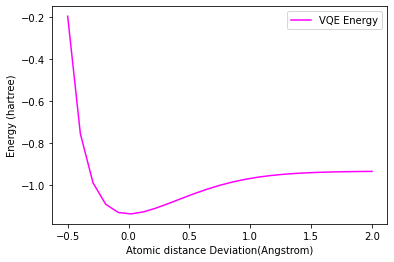

In [45]:
def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result.points) > 1:
        plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy", color = 'magenta')
        plt.xlabel('Atomic distance Deviation(Angstrom)')
        plt.ylabel('Energy (hartree)')
        plt.legend()
        plt.show()
    else:
        print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")
    
plot_energy_landscape(energy_surface_result)

For extra intuition, you may think of the energy landscape as a mountain, next to a valley, next to a plateau that a ball rolls on (the x co-ordinate of the ball corresponds the separation between the two hydrogen atoms). If the ball is not rolling too fast down the plateau (right to left) it may settle in the valley. The ball slowly rolls down the plateau because the slope is positive (representing a force of attraction between the two hydrogen atoms). If the ball overshoots the minimum point of the valley, it meets the steep negative slope of the mountain and quickly rolls back (the hydrogen atoms repell each other).

Notice the minimum is at zero. This is because we defined the hydrogen molecule's nuclei positions at the known ground state positions.

By the way, if we had used the hardware_inspired_trial we would have produced a similiar plot, however it would have had bumps because the anzatz does not capture the electronic ground state equally well at different bond lengths.

<h2><a id='exercise_3c'>Exercise 3c: Energy Landscape, To bind or not to bind?</a></h2>

The million-dollar question: Does our toy anti-retrovial bind and thus block the protease?

 - Search for the minimum from -0.5 to 5 for 30 points.
 - Give quantum-computing treatment to 2 electrons roaming over 2 orbitals

Q1. Submit the energy landscape for the anti-retroviral approaching the protease.

Q2. Is there a clear minimum at a finite separation? Does binding occur?

```
A. Yes, there is a clear minimum at 0, so binding does occur.
B. Yes, there is a clear minimum at infinity, so binding only happens at infinity.
C. No, there is no clear minimum for any separation, so binding occurs because there is no seperation.
D. No, there is no clear minimum for any separation, so there is no binding.
```

(Don't preempt the answer. Furthermore, the answer might change for other approaches and other settings, so please stick to the requested settings.)

*Feel free to use the following function, which collects the entire walk-through and refinements to Step 2 and 4. It takes in a Molecule (of refinement Step 1 type), the inputs for the other refinements and boolean choice of whether to use VQE or the numpy solver:*

In [32]:
def construct_hamiltonian_solve_ground_state(
    molecule,
    num_electrons=2,
    num_molecular_orbitals=2,
    chemistry_inspired=True,
    hardware_inspired_trial=None,
    vqe=True,
    perturbation_steps=np.linspace(-1, 1, 3),
):
    """Creates fermionic Hamiltonion and solves for the energy surface.

    Args:
        molecule (Union[qiskit_nature.drivers.molecule.Molecule, NoneType]): The molecule to simulate.
        num_electrons (int, optional): Number of electrons for the `ActiveSpaceTransformer`. Defaults to 2.
        num_molecular_orbitals (int, optional): Number of electron orbitals for the `ActiveSpaceTransformer`. Defaults to 2.
        chemistry_inspired (bool, optional): Whether to create a chemistry inspired trial state. `hardware_inspired_trial` must be `None` when used. Defaults to True.
        hardware_inspired_trial (QuantumCircuit, optional): The hardware inspired trial state to use. `chemistry_inspired` must be False when used. Defaults to None.
        vqe (bool, optional): Whether to use VQE to calculate the energy surface. Uses `NumPyMinimumEigensolver if False. Defaults to True.
        perturbation_steps (Union(list,numpy.ndarray), optional): The points along the degrees of freedom to evaluate, in this case a distance in angstroms. Defaults to np.linspace(-1, 1, 3).

    Raises:
        RuntimeError: `chemistry_inspired` and `hardware_inspired_trial` cannot be used together. Either `chemistry_inspired` is False or `hardware_inspired_trial` is `None`.

    Returns:
        qiskit_nature.results.BOPESSamplerResult: The surface energy as a BOPESSamplerResult object.
    """
    # Verify that `chemistry_inspired` and `hardware_inspired_trial` do not conflict
    if chemistry_inspired and hardware_inspired_trial is not None:
        raise RuntimeError(
            (
                "chemistry_inspired and hardware_inspired_trial"
                " cannot both be set. Either chemistry_inspired"
                " must be False or hardware_inspired_trial must be none."
            )
        )

    # Step 1 including refinement, passed in

    # Step 2a
    molecular_orbital_maker = PySCFDriver(
        molecule=molecule, unit=UnitsType.ANGSTROM, basis="sto3g"
    )

    # Refinement to Step 2a
    split_into_classical_and_quantum = ActiveSpaceTransformer(
        num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals
    )

    fermionic_hamiltonian = ElectronicStructureProblem(
        molecular_orbital_maker, [split_into_classical_and_quantum]
    )
    fermionic_hamiltonian.second_q_ops()

    # Step 2b
    map_fermions_to_qubits = QubitConverter(JordanWignerMapper())

    # Step 3a
    if chemistry_inspired:
        molecule_info = fermionic_hamiltonian.molecule_data_transformed
        num_molecular_orbitals = molecule_info.num_molecular_orbitals
        num_spin_orbitals = 2 * num_molecular_orbitals
        num_electrons_spin_up_spin_down = (
            molecule_info.num_alpha,
            molecule_info.num_beta,
        )
        initial_state = HartreeFock(
            num_spin_orbitals, num_electrons_spin_up_spin_down, map_fermions_to_qubits
        )

        chemistry_inspired_trial = UCCSD(
            map_fermions_to_qubits,
            num_electrons_spin_up_spin_down,
            num_spin_orbitals,
            initial_state=initial_state,
        )

        trial_state = chemistry_inspired_trial
    else:
        if hardware_inspired_trial is None:
            hardware_inspired_trial = TwoLocal(
                rotation_blocks=["ry"],
                entanglement_blocks="cz",
                entanglement="linear",
                reps=2,
            )

        trial_state = hardware_inspired_trial

    # Step 3b and alternative
    if vqe:
        noise_free_quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))
        solver = VQE(ansatz=trial_state, quantum_instance=noise_free_quantum_environment)
    else:
        solver = NumPyMinimumEigensolver()

    # Step 4 and alternative
    ground_state = GroundStateEigensolver(map_fermions_to_qubits, solver)

    # Refinement to Step 4
    energy_surface = BOPESSampler(gss=ground_state, bootstrap=False)
    energy_surface_result = energy_surface.sample(
        fermionic_hamiltonian, perturbation_steps
    )

    return energy_surface_result

### Your answer

The following code cells give a skeleton to call `construct_hamiltonian_solve_ground_state` and plot the results. Once you are confident with your results, submit them in the code-cell that follows.

**Note: `construct_hamiltonian_solve_ground_state` will take some time to run (approximately 2 minutes). Do not worry if it doesn't return a result immediately.**

In [58]:
# Q1

# Calculate the energies
q1_energy_surface_result = construct_hamiltonian_solve_ground_state(
    molecule = macromolecule,
    num_electrons = 2,
    num_molecular_orbitals = 2, 
    chemistry_inspired = True,
    vqe = True,
    perturbation_steps = np.linspace(-0.5, 5, 30)
)

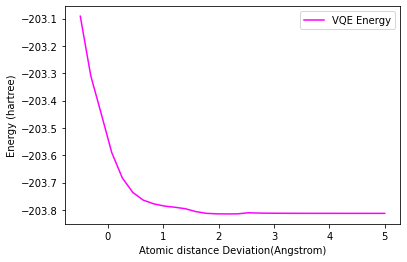

In [59]:
# Plot the energies to visualize the results
plot_energy_landscape(q1_energy_surface_result)

In [62]:
## Q2
# answer_for_ex3c_q2 = 'A'
# answer_for_ex3c_q2 = 'B'
# answer_for_ex3c_q2 = 'C'
# answer_for_ex3c_q2 = 'D'
answer_for_ex3c_q2 = 'D'

Once you are happy with the results you have acquired, submit the energies and parameters for `construct_hamiltonian_solve_ground_state` in the following cell. Change the values for all parameters, except `energy_surface`, to have the same value that you used in your call of `construct_hamiltonian_solve_ground_state`

In [63]:
from qc_grader import grade_ex3c

grade_ex3c(
    energy_surface= q1_energy_surface_result.energies,
    molecule=macromolecule,
    num_electrons=2,
    num_molecular_orbitals=2,
    chemistry_inspired=True,
    hardware_inspired_trial=None,
    vqe=True,
    perturbation_steps= np.linspace(-0.5, 5, 30),
    q2_multiple_choice=answer_for_ex3c_q2
)

Submitting your answer for ex3/partC. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<h2><a id='refine_step_3a'>4. Refining Step 3a</a></h2>

The last refinement is a lesson in how black-box tweaking can improve results.

In Step 3a, the hardware_inspired_trial is designed to run on actual current-day hardware. Recall this line from the walk-through:

In [64]:
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=2)

Let us get a feel for the `reps` (repetition) parameter. This parameter controls how many rounds of mix and rotate are applied in the trial state. In more detail: there is an initial round of rotations, before mix (often containing no parameters) and another round of rotations are repeated. Certain gates don't generate parameters (e.g. `h`, `cz`). Each round of rotations adds an extra set of parameters that the classical optimizer adjusts in the search for the ground state.

Let's relook at the simple hydrogen molecule and compute the "ideal" lowest energy electronic energy using the chemistry trial, the numpy solver and a single zero perturbation (i.e., no perturbations):

In [65]:
true_total_energy = construct_hamiltonian_solve_ground_state(
                                molecule=hydrogen_molecule_stretchable,  # Step 1
                                num_electrons=2,                         # Step 2a
                                num_molecular_orbitals=2,                # Step 2a
                                chemistry_inspired=True,                 # Step 3a
                                vqe=False,                               # Step 3b
                                perturbation_steps = [0])                # Step 4
plot_energy_landscape(true_total_energy)

Total Energy is:  -1.137306035753395 hartree
(No need to plot, only one configuration calculated.)


We take this as the true value for the rest of our experiment.

*Next, select `chemistry_inspired=False`, `vqe=True` and pass in a hardware trial with 1 round*:

In [83]:
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=1)

quantum_calc_total_energy = construct_hamiltonian_solve_ground_state(
                                molecule=hydrogen_molecule_stretchable,           # Step 1
                                num_electrons=2,                                  # Step 2a
                                num_molecular_orbitals=2,                         # Step 2a
                                chemistry_inspired=False,                         # Step 3a
                                hardware_inspired_trial=hardware_inspired_trial,  # Step 3a
                                vqe=True,                                         # Step 3b
                                perturbation_steps = [0])                         # Step 4
plot_energy_landscape(quantum_calc_total_energy)

Total Energy is:  -1.1169982954371371 hartree
(No need to plot, only one configuration calculated.)


*Notice the difference is small and positive:*


In [84]:
quantum_calc_total_energy.energies[0] - true_total_energy.energies[0]

0.020307740316257927

*Let's see how many parameters are used to specify the trial state:*

In [85]:
total_number_of_parameters = len(hardware_inspired_trial._ordered_parameters)
print("Total number of adjustable parameters: ", total_number_of_parameters)

Total number of adjustable parameters:  8


<h2><a id='exercise_3d'>Exercise 3d: The effect of more repetitions</a></h2>

Q1: Try reps equal to 1 (done for you) and 2 and compare the errors. What happens to the error? Does it increase, decrease, or stay the same?
Be aware that:
 - VQE is a statistical algorithm, so run it a few times before observing the pattern.
 - Going beyond 2 may not continue the pattern.
 - Note that `reps` is defined in `TwoLocal`

Q2: Check the total number of parameters for reps equal 1 and 2. How many parameters are introduced per round of rotations?

## Write your answer here:

**Enter your answer to the first multiple choice question in the code-cell below and add your answer for Q2. Run the cell to submit your answers.**

In [80]:
hardware_inspired_trial2 = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=2)

quantum_calc_total_energy2 = construct_hamiltonian_solve_ground_state(
                                molecule=hydrogen_molecule_stretchable,           # Step 1
                                num_electrons=2,                                  # Step 2a
                                num_molecular_orbitals=2,                         # Step 2a
                                chemistry_inspired=False,                         # Step 3a
                                hardware_inspired_trial=hardware_inspired_trial2,  # Step 3a
                                vqe=True,                                         # Step 3b
                                perturbation_steps = [0])                         # Step 4
plot_energy_landscape(quantum_calc_total_energy2)

Total Energy is:  -1.1373054154711517 hartree
(No need to plot, only one configuration calculated.)


In [81]:
quantum_calc_total_energy2.energies[0] - true_total_energy.energies[0]

6.202822433465371e-07

In [82]:
total_number_of_parameters2 = len(hardware_inspired_trial2._ordered_parameters)
print("Total number of adjustable parameters: ", total_number_of_parameters2)

Total number of adjustable parameters:  12


In [86]:
from qc_grader import grade_ex3d

## Q1
answer_for_ex3d_q1 = 'decreases'
# answer_for_ex3d_q1 = 'increases'
# answer_for_ex3d_q1 = 'stays the same'
##


## Q2
answer_for_ex3d_q2 = 4
##

grade_ex3d(answer_for_ex3d_q1, answer_for_ex3d_q2)

Submitting your answer for ex3/partD. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<h2><a id='exercise_3e'>Exercise 3e: Open-ended: Find the best hardware_inspired_trial to minimize the Energy Error for the Macromolecule</a></h2>

Turning to the macromolecule again. Using, `chemistry_inspired=False`, `vqe=True`, `perturbation_steps = [0]`, a maximum of 8 qubits, and your own hardware_inspired_trial with any combination of options from the walk-through; find the lowest energy. Your answer to this exercise includes all parameters passed to `construct_hamiltonian_solve_ground_state` and the result object it returns. This exercise is scored based on how close your computed energy $E_{computed}$ is to the "true" minimum energy of the macromolecule $E_{true}$. This score is calculated as shown below, rounded to the nearest integer.

$$\text{score} = -10 \times \log_{10}{\left(\left\lvert{\frac{E_{true} - E_{computed}}{E_{true}}}\right\rvert\right)}$$

Achieving a smaller error in your computed energy will increase your score. For example, if the true energy is -42.141 and you compute -40.0, you would have a score of 13. Use the following code cell to trial different `hardware_inspired_trial`s.

In [133]:
# Modify the following variables
num_electrons = 2
num_molecular_orbitals = 2
hardware_inspired_trial = TwoLocal(rotation_blocks = ['rx','rz'], entanglement_blocks = ['cx'],
                                   entanglement='linear', reps=1)


computed_macromolecule_energy_result = construct_hamiltonian_solve_ground_state(
   molecule=macromolecule,
   num_electrons=num_electrons,
   num_molecular_orbitals=num_molecular_orbitals,
   chemistry_inspired=False,
   hardware_inspired_trial=hardware_inspired_trial,
   vqe=True,
   perturbation_steps=[0],
)

Once you are ready to submit your answer, run the following code cell to have your computed energy scored. You can submit multiple times.

In [134]:
from qc_grader import grade_ex3e

grade_ex3e(
   energy_surface_result=computed_macromolecule_energy_result,
   molecule=macromolecule,
   num_electrons=num_electrons,
   num_molecular_orbitals=num_molecular_orbitals,
   chemistry_inspired=False,
   hardware_inspired_trial=hardware_inspired_trial,
   vqe=True,
   perturbation_steps=[0],
)

Submitting your answer for ex3/partE. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 61.


----------------

#### <a id='qresource'>Quantum Chemistry Resources</a>
*Videos*
- *Quantum Chemistry I: Obtaining the Qubit Hamiltonian* 
    - https://www.youtube.com/watch?v=2XEjrwWhr88
- *Quantum Chemistry II: Finding the Ground States* 
    - https://www.youtube.com/watch?v=_UW6puuGa5E 
    - https://www.youtube.com/watch?v=o4BAOKbcd3o
*Tutorials*
- https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html 
- https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html 
- https://qiskit.org/documentation/nature/tutorials/05_Sampling_potential_energy_surfaces.html
*Code References*
- UCCSD : https://qiskit.org/documentation/stubs/qiskit.chemistry.components.variational_forms.UCCSD.html
- ActiveSpaceTransformer: https://qiskit.org/documentation/nature/stubs/qiskit_nature.transformers.second_quantization.electronic.ActiveSpaceTransformer.html?highlight=activespacetransformer#qiskit_nature.transformers.second_quantization.electronic.ActiveSpaceTransformer

Licensing and notes:
- All images used, with gratitude, are listed below with their respective licenses:
  - https://de.wikipedia.org/wiki/Datei:Teppichschere.jpg by CrazyD is licensed under CC BY-SA 3.0
  - https://commons.wikimedia.org/wiki/File:The_structure_of_the_immature_HIV-1_capsid_in_intact_virus_particles.png by MarinaVladivostok is licensed under CC0 1.0
  - https://commons.wikimedia.org/wiki/File:Peptidformationball.svg by YassineMrabet is licensed under the public domain
  - The remaining images are either IBM-owned, or hand-generated by the authors of this notebook.

- HCONH2 (Formamide) co-ordinates kindly provided by the National Library of Medicine:
  - `National Center for Biotechnology Information (2021). PubChem Compound Summary for CID 713, Formamide. https://pubchem.ncbi.nlm.nih.gov/compound/Formamide.`
- For further information about the Pauli exclusion principle:
https://en.wikipedia.org/wiki/Pauli_exclusion_principle
- We would like to thank collaborators, Prof Yasien and Prof Munro from Wits for extensive assistance.
- We would like to thank all the testers and feedback providers for their valuable input.


In [2]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

Qiskit Software,Version
qiskit-terra,0.18.1
qiskit-aer,0.8.2
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.16.0
qiskit-aqua,0.9.4
qiskit,0.29.0
qiskit-nature,0.1.5
qiskit-finance,0.2.0
qiskit-optimization,0.2.1
qiskit-machine-learning,0.2.0
